## Binary classification with degraded and distorted speech
### Laura Fernández Gallardo

Using models trained with clean speech, analyze the effects of testing with distorted speech on the classification performance.

* WAAT classification
* multilabel classification

As done when tuning models, the evaluation metric considered is the **average per-class accuracy**.

In [1]:
import io
import requests
import pickle # save / load models
from ast import literal_eval # parsing hp of gridsearch

import numpy as np
import pandas as pd

from cls_tuning import * # my helper functions

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

## Features from degraded and distorted speech

**Speech degradations:** The [NSC](http://www.qu.tu-berlin.de/?id=nsc-corpus) stimuli files (shortened semi-spontaneous dialog 6) have been transmitted through 53 channel degradations (see [readme](https://github.com/laufergall/ML_Speaker_Characteristics/tree/master/data/distortions)). This makes a total of 15900 files, corresponding to 53 degradations x 300 speakers. 

**Speech distortions:** 4 packet loss and 2 jitter conditions were then applied to the 15900 files, resulting in a maximum of 4 x 2 x 15900 = 127200 files. Regrettably, about 7% of the transmission simulations were unsuccessfull (the received speech files were corrupt). Each successfully transmitted file was splitted into two and OpenSMILE speech features were [extracted](https://github.com/laufergall/ML_Speaker_Characteristics/tree/master/feature_extraction) from each of the halves. Speech features are available from a total of 235709 instances, coded by the speaker and distortions applied.  

The same set of speech features was also extracted from clean speech (all semi-spontaneous dialogs, see previous jupyter notebooks in this folder), from the 300 clean speech files corresponding to stimuli segments, and from the 15900 files of degraded stimuli segments (no packet loss or jitter conditions). 

In [3]:
# load features from clean speech

path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/extracted_features/"

# features used for train (not test)
url = path + "/eGeMAPSv01a_semispontaneous_splitted.csv"
s = requests.get(url).content
feats_clean =pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ';') # shape: 3591, 89

# extract speaker ID and dialog number from speech file name
feats_clean['spkID'] = feats_clean['name'].str.slice(2, 5).astype('int')
feats_clean['dialog'] = feats_clean['name'].str.slice(-9,-8)

# appending class label
classes = pd.read_csv(r'..\data\generated_data\speakerIDs_cls_WAAT_all.csv') # only high/low WAAT
feats_clean_class = pd.merge(feats_clean, classes, how='inner')
feats_clean_class.head()

,name,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,...,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,spkID,dialog,gender,class
0,'m006_rabat_d5_01.wav',31.23358,0.262306,26.59388,30.09026,34.11197,7.518097,316.59510,610.79350,267.6818,...,2.643574,0.201035,0.209331,0.180400,0.286503,-30.14587,6,5,m,high
1,'m006_rabat_d5_02.wav',31.31265,0.205003,27.27562,31.13765,34.80304,7.527420,90.15386,78.50047,223.4587,...,1.550388,0.253529,0.187034,0.405807,0.462146,-30.21316,6,5,m,high
2,'m006_rabat_d5_03.wav',32.08952,0.210413,27.79275,31.72719,35.72678,7.934029,277.98860,632.48160,139.8396,...,2.132591,0.233043,0.190101,0.229767,0.381140,-29.06304,6,5,m,high
3,'m006_rabat_d6_01.wav',32.86148,0.209119,28.24504,32.85449,37.06210,8.817057,299.96070,709.52120,171.5547,...,1.770956,0.304667,0.248820,0.247241,0.419860,-27.91848,6,6,m,high
4,'m006_rabat_d6_02.wav',31.04583,0.249890,26.29376,29.80590,33.76602,7.472261,191.92640,177.29000,113.4793,...,1.890136,0.239687,0.185363,0.317407,0.477544,-29.62095,6,6,m,high


In [4]:
# load features from clean stimuli 
# used as clean condition when evaluating test performance 

# (gitignored file)
file_feats = r'..\data\extracted_features\eGeMAPSv01a_stimuli_splitted.csv'
feats_clean = pd.read_csv(file_feats, sep=';') # shape (600, 89)

# extract speaker ID from speech file name
feats_clean['spkID'] = feats_clean['name'].str.slice(2, 5).astype('int')

# distortion code
feats_clean['distnum'] = '00'

# add column with packet loss info
feats_clean['packetlossrate'] = '0'

## add column with jitter info
feats_clean['jitterms'] = '0'

In [5]:
# load features from degraded stimuli

# (gitignored file)
file_feats = r'..\data\extracted_features\eGeMAPSv01a_stimuli_splitted_degraded.csv'
feats_deg = pd.read_csv(file_feats, sep=';') # shape (31800, 89)

# extract speaker ID from speech file name
feats_deg['spkID'] = feats_deg['name'].str.slice(1, 4).astype('int')

# distortion code
feats_deg['distnum'] = feats_deg['name'].str.slice(5,7)

# add column with packet loss info
feats_deg['packetlossrate'] = '0'

## add column with jitter info
feats_deg['jitterms'] = '0'


In [6]:
# load features from degraded+distorted stimuli (packet loss and jitter)

# (gitignored file)
file_feats = r'..\data\extracted_features\eGeMAPSv01a_stimuli_splitted_distorted.csv'
feats_dist = pd.read_csv(file_feats) # shape (235709, 89)

# extract speaker ID from speech file name
feats_dist['spkID'] = feats_dist['name'].str.slice(1, 4).astype('int')

# distortion code
feats_dist['distnum'] = feats_dist['name'].str.slice(5,7)

# add column with packet loss info
feats_dist['packetlossrate'] = feats_dist['name'].str.extract('(?<=P)(.*?)(?=-)', expand=False)

## add column with jitter info
feats_dist['jitterms'] = feats_dist['name'].str.extract('(?<=J)(.*?)(?=%)', expand=False)


In [7]:
# join degraded with degraded+distorted stimuli instances
feats_dist = feats_dist.append(feats_deg) # shape (267509, 93)

# join degraded and degraded+distorted with clean stimuli instances
feats_dist = feats_dist.append(feats_clean) # shape (268109, 93)

In [8]:
# load mapping of degradation names

path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/distortions/"
url = path + "dist_mapping.csv"
s = requests.get(url).content
dist_mapping =pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ';')

# padding distortion codes with zeroes
dist_mapping['distnum'] = dist_mapping['distnum'].astype(str).str.zfill(2)

# merge feats with distmapping to know name of distortions
feats_dist = feats_dist.merge(dist_mapping)

# appending class label
feats_dist_class = pd.merge(feats_dist, classes, how='inner')
feats_dist_class.to_csv(r'.\data_while_tuning\feats_dist_class.csv', index=False)

In [9]:
# how many degradations
print(feats_dist['distcode'].value_counts().mean()) # around 5000 instances for each degradation
print(len(feats_dist['distcode'].value_counts())) # 53 degradations
print(feats_dist['packetlossrate'].value_counts()) # around 30K instances for each packet loss rate * 2 jitter conditions

4964.981481481482
54
1     61382
3     59997
5     58761
10    55569
0     32400
Name: packetlossrate, dtype: int64


## WAAT classification

The WAAT (warmth-attractiveness) score distribution was already explored [here](https://github.com/laufergall/ML_Speaker_Characteristics/blob/master/classification/02_evaluating_classification_WAAT.ipynb)

This notebook: binary classification with data partitions:

* train: clean speech data from semi-spontaneous dialogs: 5, 6, 7, and 8.
* test: clean or degraded/distorted data from NSC stimuli (shortened semi-spontaneous dialog 6, same speakers. See [extracted_features](https://github.com/laufergall/ML_Speaker_Characteristics/tree/master/data/extracted_features))

(different from the splitting speakers strategy of Part I, where the test data consisted on "unseen" sepakers).

In [10]:
# train data
dialogs_train = ['5', '6', '7', '8']
feats_clean_class_train = feats_clean_class.loc[feats_clean_class['dialog'].isin(dialogs_train)] # shape (1647, 93)

# test data: each degradation / distortion in feats_dist_class

### Model tuning

In [11]:
# Standardize speech features  

# learn transformation on training data
scaler = StandardScaler()
scaler.fit(feats_clean_class_train.drop(['name','spkID','dialog','gender','class'],axis=1))
pickle.dump(scaler, open(r'.\data_while_tuning\scaler_feats_clean_class_train.sav', 'wb'))

# numpy n_instances x n_feats
feats_s_train = scaler.transform(feats_clean_class_train.drop(['name','spkID','dialog','gender','class'],axis=1))

In [12]:
# training data. Features and labels
X = feats_s_train
y = feats_clean_class_train['class'].astype('category').cat.codes

feats_clean_class_train['genderclass']= feats_clean_class_train[['gender', 'class']].apply(lambda x: ''.join(x), axis=1)

feats_names = pd.read_csv(r'.\data_while_tuning\feats_names.csv', header = None)
feats_names = feats_names.values.tolist()

In [13]:
# split train data into 80% and 20% subsets - with balance in trait and gender
# give subset A to the inner hyperparameter tuner
# and hold out subset B for meta-evaluation


AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, stratify = feats_clean_class_train['genderclass'], random_state=2302)

print('Number of instances in A (hyperparameter tuning):',AX.shape[0])
print('Number of instances in B (meta-evaluation):',BX.shape[0])

Number of instances in A (hyperparameter tuning): 1756
Number of instances in B (meta-evaluation): 440


In [14]:
# dataframe with results from hp tuner to be appended
tuning_all = pd.DataFrame()

# list with tuned classifiers trained on training data, to be appended
trained_all = []

# label: str to keep track of the different runs in the filename
label='d5d6d7d8'

Tuning classifiers: 
* K Nearest Neighbors
* SVC with rbf kernel
* Logistic Regression
* Random Forest

These classifiers performed good for WAAT classification of clean speech (tested with unseen speakers). 

Using the same approach and same ranges for hyperparameter search as found in [Part 02](https://github.com/laufergall/ML_Speaker_Characteristics/blob/master/classification/02_evaluating_classification_WAAT.ipynb)).

In [15]:
from sklearn.neighbors import KNeighborsClassifier

"""
K Nearest Neighbors
"""
def get_KNeighborsClassifier2tune():

    model = KNeighborsClassifier()
    hp = dict(
        classifier__n_neighbors = list(range(1,8))
    )
    return 'KNeighborsClassifier', model, hp

k_gridsearch = np.arange(10, 88, 1)

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                               [get_KNeighborsClassifier2tune], 
                               feats_names, 
                               k_gridsearch,
                               'random',
                               n_iter=80
                              )

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'KNeighborsClassifier' -> Best cross-val score on A set: 0.873853 using {'selecter__k': 76, 'classifier__n_neighbors': 1}
'KNeighborsClassifier' -> Average per-class accuracy on B set: 0.885789



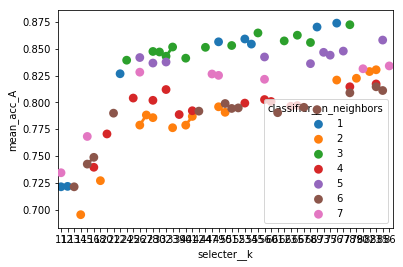

In [16]:
# open generated file with results of fitting search
 
sgrid = pd.read_csv(r'.\data_while_tuning\KNeighborsClassifier_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__n_neighbors', data=sgrid.join(params_df)) 

In [17]:
from sklearn.svm import SVC

"""
Support Vector Machines
"""
def get_SVCrbf2finetune():
    
    model = SVC()
    hp = dict(
        classifier__C = np.logspace(2,4,num=5),
        classifier__kernel = ['rbf'],
        classifier__gamma = np.logspace(-5,-3,num=3)
    )
    return 'SVCrbf', model, hp

k_gridsearch = np.arange(70, 88, 1)

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                               [get_SVCrbf2finetune], 
                               feats_names, 
                               k_gridsearch,
                               'random',
                               n_iter=50
                              )

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'SVCrbf' -> Best cross-val score on A set: 0.871908 using {'selecter__k': 77, 'classifier__kernel': 'rbf', 'classifier__gamma': 0.001, 'classifier__C': 3162.2776601683795}
'SVCrbf' -> Average per-class accuracy on B set: 0.872211



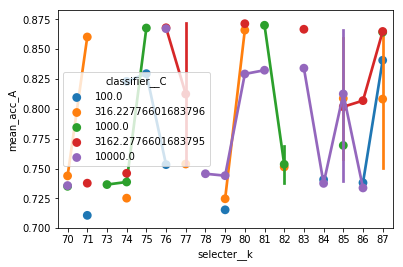

In [18]:
# rbf kernel: open generated file with results of fitting search
 
sgrid = pd.read_csv(r'.\data_while_tuning\SVCrbf_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__C', data=sgrid.join(params_df))

In [32]:
from sklearn.linear_model import LogisticRegression

"""
Logistic Regression
"""
def get_LogisticRegression2tune():

    model = LogisticRegression()
    hp = dict(
        #classifier__penalty = ['l1','l2'],
        classifier__C = np.logspace(-3,3,num=7)
    )
    return 'LogisticRegression', model, hp

k_gridsearch = np.arange(10, 88, 1)

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_LogisticRegression2tune], 
                           feats_names,
                           k_gridsearch,
                           'random',
                           n_iter=50 
                          )

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'LogisticRegression' -> Best cross-val score on A set: 0.739749 using {'selecter__k': 86, 'classifier__C': 0.10000000000000001}
'LogisticRegression' -> Average per-class accuracy on B set: 0.729579



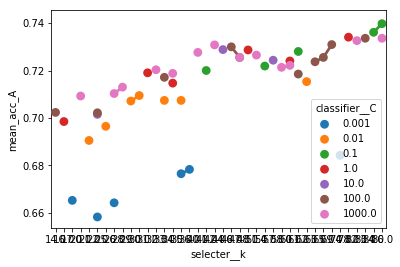

In [33]:
# open generated file with results of fitting search
 
sgrid = pd.read_csv(r'.\data_while_tuning\LogisticRegression_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__C', data=sgrid.join(params_df)) 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

"""
Random Forest
"""
def get_RandomForestClassifier2tune():
    
    model = RandomForestClassifier(random_state=2302, max_features = None)
    hp = dict(
        classifier__n_estimators = np.arange(27,35)
    )
    return 'RandomForestClassifier', model, hp

k_gridsearch = np.arange(70, 89)

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                               [get_RandomForestClassifier2tune], 
                               feats_names, 
                               k_gridsearch,
                               'random',
                               n_iter=70
                              )

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

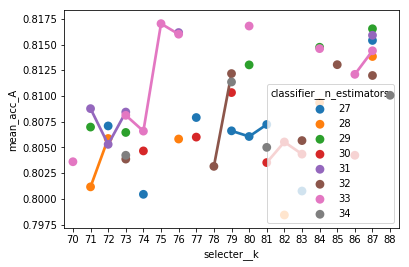

In [37]:
# open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\RandomForestClassifier_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
#fig, ax = plt.subplots(figsize=(15,15))
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__n_estimators', data=sgrid.join(params_df))

In [53]:
# save tuning_all (.csv) and trained_all (nameclassifier.sav)
save_tuning(tuning_all, trained_all, label)

### Testing across channel degradations and distortions

In [3]:
# if new ipynb session: 

# load tuning_all and trained_all
label='d5d6d7d8'
tuning_all, trained_all = load_tuning(label)

# load mapping of degradation names
path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/distortions/"
url = path + "dist_mapping.csv"
s = requests.get(url).content
dist_mapping =pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ';')

# load data
feats_dist_class = pd.read_csv(r'.\data_while_tuning\feats_dist_class.csv')

# load scaler
scaler = pickle.load(open(r'.\data_while_tuning\scaler_feats_clean_class_train.sav', 'rb'))

In [4]:
# select the classifier that gave the maximum acc on B set
best_accs = tuning_all['best_accs']
i_best = best_accs.idxmax()

print('Selected classifier based on the best performance on B: %r (accB = %0.2f)' 
      % (tuning_all.loc[i_best,'classifiers_names'], round(tuning_all.loc[i_best,'best_accs'],2)))

tuning_all

Selected classifier based on the best performance on B: 'KNeighborsClassifier' (accB = 0.89)


,best_accs,best_hps,classifiers_names,sel_feats,sel_feats_i
0,0.885789,"{'selecter__k': 76, 'classifier__n_neighbors': 1}",KNeighborsClassifier,"[[""'F0semitoneFrom27.5Hz_sma3nz_amean'""], [""'F...",[ True True False True True True True Tr...
1,0.872211,"{'selecter__k': 77, 'classifier__kernel': 'rbf...",SVCrbf,"[[""'F0semitoneFrom27.5Hz_sma3nz_amean'""], [""'F...",[ True True False True True True True Tr...
2,0.729579,"{'selecter__k': 86, 'classifier__C': 0.1000000...",LogisticRegression,"[[""'F0semitoneFrom27.5Hz_sma3nz_amean'""], [""'F...",[ True True True True True True True Tr...
3,0.781053,"{'selecter__k': 75, 'classifier__n_estimators'...",RandomForestClassifier,"[[""'F0semitoneFrom27.5Hz_sma3nz_amean'""], [""'F...",[ True True False True True True True Tr...


Same as in Part I, we compute the average per-class accuracy given the predictions made for each speaker (decided by majority voting)

In [5]:
def mj_preds(yt, yt_pred, feats_cond_class):
    """
    Majority voting of class predictions of instances, grouped by speakers

    Input:
    - yt: true class for all instances
    - yt_pred: predicted class for all instances
    - feats_cond_class: dataframe with classes and spkID (same number of instances as yt and yt_pred)
    
    Output:
    - yt: true class per speaker
    - yt_pred_spk: predicted class per speaker
    - yt_pred_spk_conf: conf measure for the prediction per speaker, ranging from 0 to 1
    """
    # new df with true and predicted classes
    test_scores = pd.DataFrame(data = feats_cond_class[['spkID','class']])
    test_scores['yt'] = yt
    test_scores['yt_pred'] = yt_pred

    # group by speakers and compute prediction confidence based on the distance from 0.5
    test_scores_spk = test_scores.groupby('spkID').mean()
    conf = abs(0.5-test_scores_spk)/0.5
    yt_pred_spk_conf = conf['yt_pred']

    # compute scores after 'majority voting'
    yt_spk = test_scores_spk.round().astype(int)['yt']
    yt_pred_spk = test_scores_spk.round().astype(int)['yt_pred']

    return yt_spk, yt_pred_spk, yt_pred_spk_conf


Performance under clean test speech:

In [6]:
                
# loop over tuned classifiers
for c in np.arange(tuning_all.shape[0]):

    # score in dev set
    print('%r -> Clean development set (B), average per-class accuracy (per instance)=%.2f' % (tuning_all.loc[c,'classifiers_names'], 
                                                                                           tuning_all.loc[c,'best_accs']))

    feats_cond_class = feats_dist_class[feats_dist_class['distcode']=='Clean']

    # scaling test features with the transformation learnt in training
    dropcolumns=['name','spkID','distnum','packetlossrate','jitterms','distcode','gender','class']
    feats_s_test = scaler.transform(feats_cond_class.drop(dropcolumns,axis=1)) 

    # test data. Features and labels
    Xt = feats_s_test
    yt = feats_cond_class['class'].astype('category').cat.codes

    # predictions on the test set 
    # feat sel on Xt is performed by the classifier
    yt_pred = trained_all[c][0].predict(Xt)

    # score per instance
    recallscore = recall_score(yt, yt_pred, average='macro')
    print('%r -> Clean test speech, average per-class accuracy (per instance)=%.2f' % (tuning_all.loc[c,'classifiers_names'], recallscore))

    # score per speaker
    yt_spk, yt_pred_spk, yt_pred_spk_conf = mj_preds(yt, yt_pred, feats_cond_class)
    recallscore_spk = recall_score(yt_spk, yt_pred_spk, average='macro')
    print('%r -> Clean test speech, average per-class accuracy (per speaker)=%.2f' % (tuning_all.loc[c,'classifiers_names'], recallscore_spk))


'KNeighborsClassifier' -> Clean development set (B), average per-class accuracy (per instance)=0.89
'KNeighborsClassifier' -> Clean test speech, average per-class accuracy (per instance)=0.64
'KNeighborsClassifier' -> Clean test speech, average per-class accuracy (per speaker)=0.62
'SVCrbf' -> Clean development set (B), average per-class accuracy (per instance)=0.87
'SVCrbf' -> Clean test speech, average per-class accuracy (per instance)=0.72
'SVCrbf' -> Clean test speech, average per-class accuracy (per speaker)=0.71
'LogisticRegression' -> Clean development set (B), average per-class accuracy (per instance)=0.73
'LogisticRegression' -> Clean test speech, average per-class accuracy (per instance)=0.69
'LogisticRegression' -> Clean test speech, average per-class accuracy (per speaker)=0.66
'RandomForestClassifier' -> Clean development set (B), average per-class accuracy (per instance)=0.78
'RandomForestClassifier' -> Clean test speech, average per-class accuracy (per instance)=0.67
'Ra

Performance under degraded test speech:

In [7]:

# loop over tuned classifiers
for c in np.arange(tuning_all.shape[0]):

    dist_codes = dist_mapping['distcode']
    packetlossrate_codes = feats_dist_class['packetlossrate'].unique()
    jitterms_codes = feats_dist_class['jitterms'].unique()

    test_performance = pd.DataFrame() # append results for each condition


    # loop over each degradations / distortions in feats_dist_class

    for i in np.arange(len(dist_codes)):
        for j in np.arange(len(packetlossrate_codes)):
            for k in np.arange(len(jitterms_codes)):

                # selecting features of one condition given by i, j, k
                cond1 = feats_dist_class['distcode']==dist_codes[i] 
                cond2 = feats_dist_class['packetlossrate']==packetlossrate_codes[j] 
                cond3 = feats_dist_class['jitterms']==jitterms_codes[k] 
                feats_cond_class = feats_dist_class.loc[cond1 & cond2 & cond3]

                if feats_cond_class.shape[0] > 0:

                    # scaling test features with the transformation learnt in training
                    dropcolumns=['name','spkID','distnum','packetlossrate','jitterms','distcode','gender','class']
                    feats_s_test = scaler.transform(feats_cond_class.drop(dropcolumns,axis=1)) 

                    # test data. Features and labels
                    Xt = feats_s_test
                    yt = feats_cond_class['class'].astype('category').cat.codes

                    # predictions on the test set 
                    # feat sel on Xt is performed by the classifier
                    yt_pred = trained_all[c][0].predict(Xt)

                    # score per speaker
                    yt_spk, yt_pred_spk, yt_pred_spk_conf = mj_preds(yt, yt_pred, feats_cond_class)
                    recallscore_spk = recall_score(yt_spk, yt_pred_spk, average='macro')

                    # create the output dataframe
                    d = {
                        'degradation': dist_codes[i],
                        'packetlossrate': packetlossrate_codes[j],
                        'jitterms': jitterms_codes[k],
                        'average per-class accuracy': round(float(recallscore_spk),2),
                    }
                    res = pd.DataFrame(data = d, index=[0])

                    test_performance = test_performance.append(res, ignore_index=True)

    # save test_performance as csv
    test_performance['distortion']= test_performance[['packetlossrate', 'jitterms']].apply(lambda x: 'pl'+str(x[0]).zfill(2)+'ji'+str(x[1]).zfill(2), axis=1)
    test_performance['bandwidth']=test_performance['degradation'].str.slice(0,2)
    test_performance['codec'] = test_performance['degradation'].str.extract('(?<=B_)(.*?)(?=_)', expand=False)

    test_performance.to_csv(r'.\performance_channels\cls_test_distortionsdegradations_'+tuning_all.loc[c,'classifiers_names']+'_'+label+'.csv', index=False)

Visualization:

* For each tuned classifier:
    * Performance across degradations and distortions for each bandwidth separately
    * effects of packet loss
    * effects of jitter

In [8]:
def plot_performance_across_deg_dist(test_performance, bw, pl, ji):
    """
    Plot performance across channel conditions, defined in bw, pl, ji

    Input:
    - test_performance: dataframe with performance across channel conditions
    - bw: list of strings with bandwidth conditions to plot
    - pl: list of strings with packet loss conditions to plot
    - ji: list of strings with jitter conditions to plot
    """
    fig, ax = plt.subplots(figsize=[10, 6])

    # data to plot
    mdata = test_performance[test_performance['bandwidth'].isin(bw)]
    mdata = mdata[mdata['packetlossrate'].isin(pl)]
    mdata = mdata[mdata['jitterms'].isin(ji)]
    ndegs = len(mdata['degradation'].unique())

    # pointplot
    myfig = sns.pointplot(
        x='degradation', 
        y='average per-class accuracy',
        hue='codec', # distortion
        data=mdata
    ) 

    # add dashed line indicating test performance with clean data
    # test performance with clean data
    testacc_clean = test_performance.loc[test_performance['degradation']=='Clean','average per-class accuracy']
    plt.plot(np.linspace(0,ndegs,1000), [testacc_clean]*1000, 'k--')
    plt.text(0, testacc_clean-0.01, 'Clean test data')

    # rotate x axis and limit y axis
    for item in myfig.get_xticklabels():
        item.set_rotation(90)
    plt.ylim(0.40, 0.80)
    ax.legend_.remove()
    
    cond_str = tuning_all.loc[c,'classifiers_names']+label+'_bw'+'-'.join(bw)+'_pl'+'-'.join(pl)+'_ji'+'-'.join(ji)
    plt.title('Binary WAAT classification with '+ cond_str)

    filename = r'\cls_WAAT_binary_performance_'+ cond_str +'.png'
    myfig.get_figure().savefig(r'.\figures' + filename, bbox_inches = 'tight')    

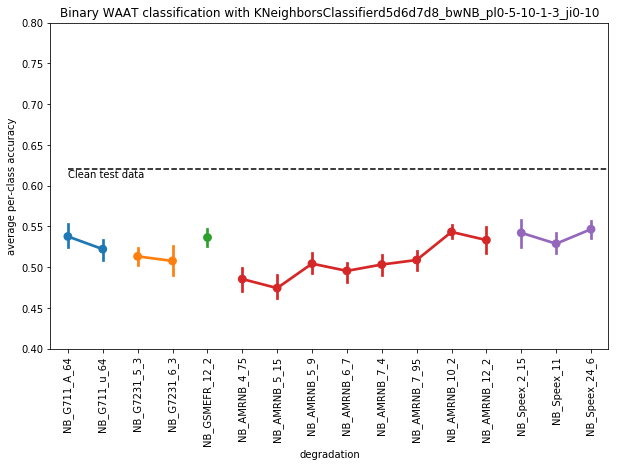

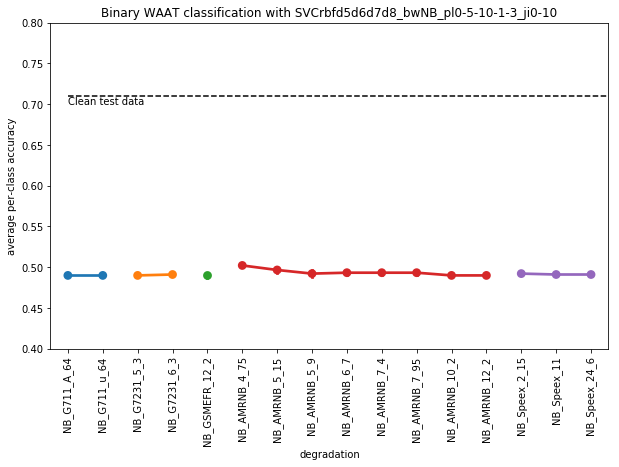

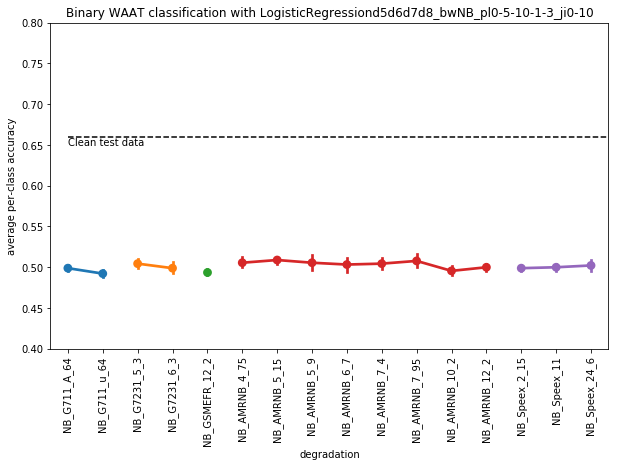

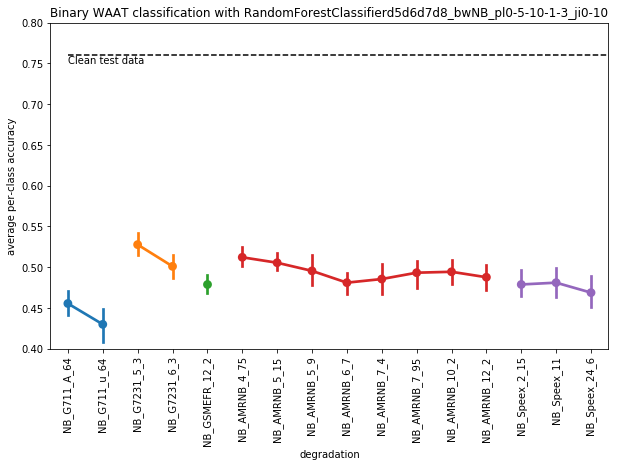

In [9]:
# narrowband degradations

for c in np.arange(tuning_all.shape[0]):
    test_performance = pd.read_csv(r'.\performance_channels\cls_test_distortionsdegradations_'+tuning_all.loc[c,'classifiers_names']+'_'+label+'.csv')
    bw=['NB']
    pl=list(test_performance['packetlossrate'].unique().astype(str))
    ji=list(test_performance['jitterms'].unique().astype(str))
    plot_performance_across_deg_dist(test_performance, bw, pl, ji)

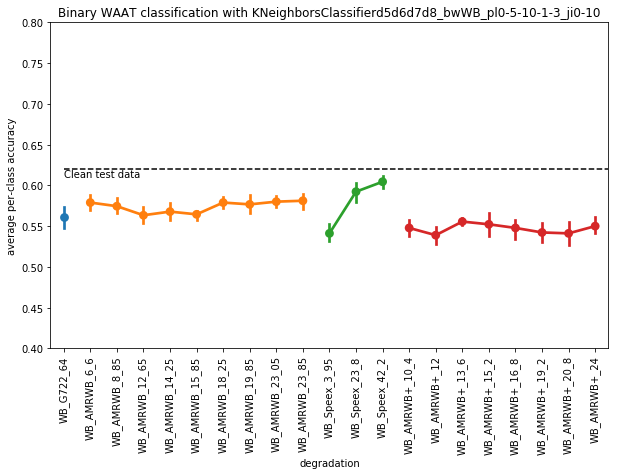

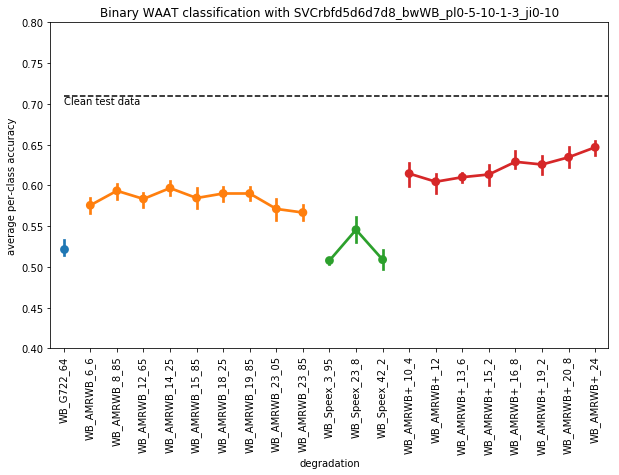

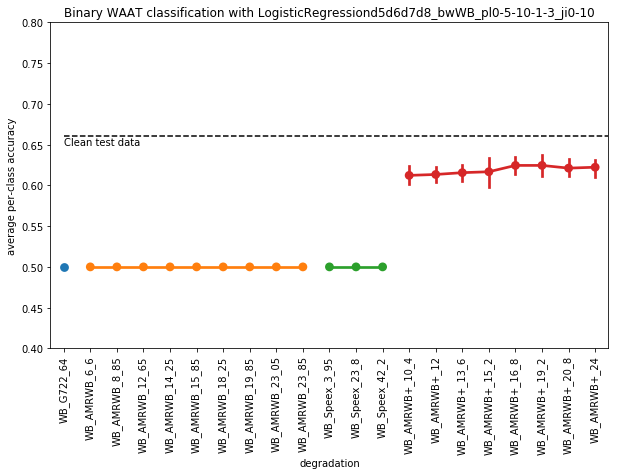

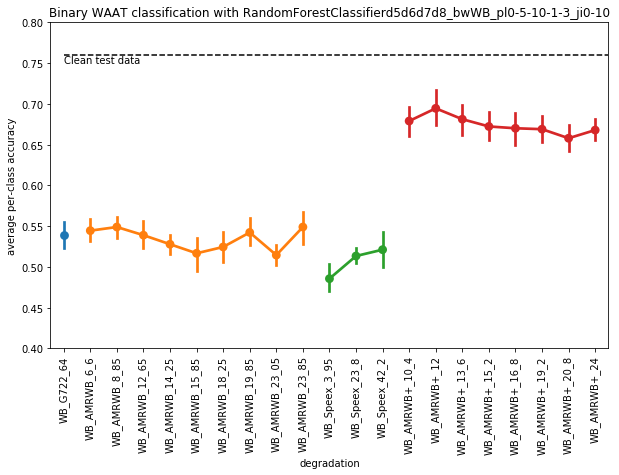

In [10]:
# wideband degradations

for c in np.arange(tuning_all.shape[0]):
    test_performance = pd.read_csv(r'.\performance_channels\cls_test_distortionsdegradations_'+tuning_all.loc[c,'classifiers_names']+'_'+label+'.csv')
    bw=['WB']
    pl=list(test_performance['packetlossrate'].unique().astype(str))
    ji=list(test_performance['jitterms'].unique().astype(str))
    plot_performance_across_deg_dist(test_performance, bw, pl, ji)

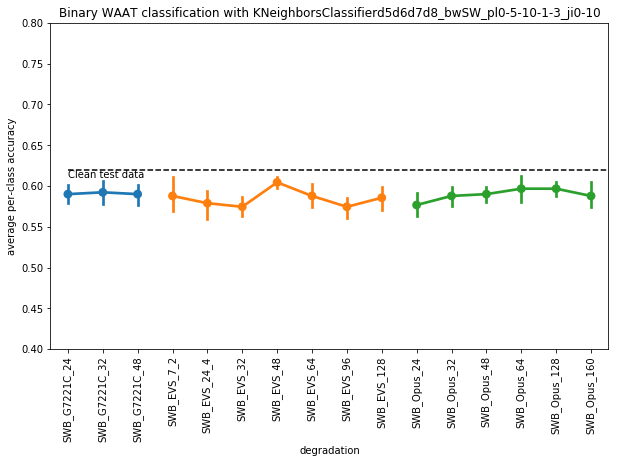

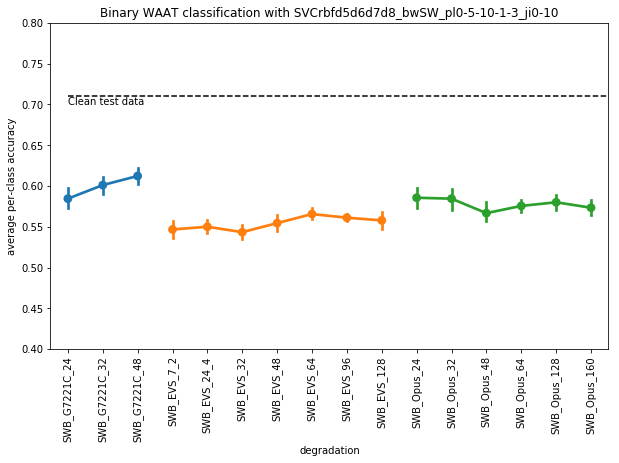

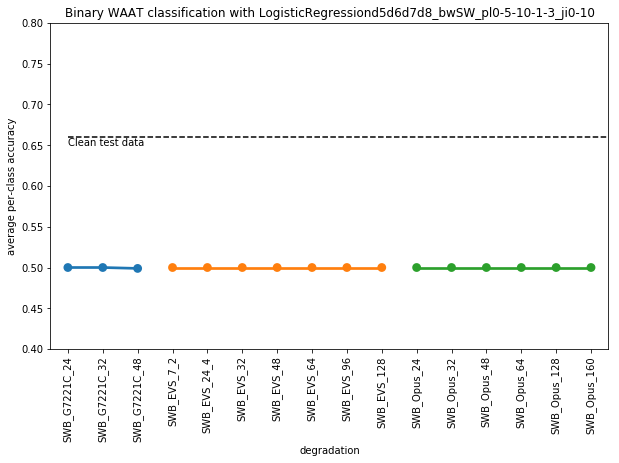

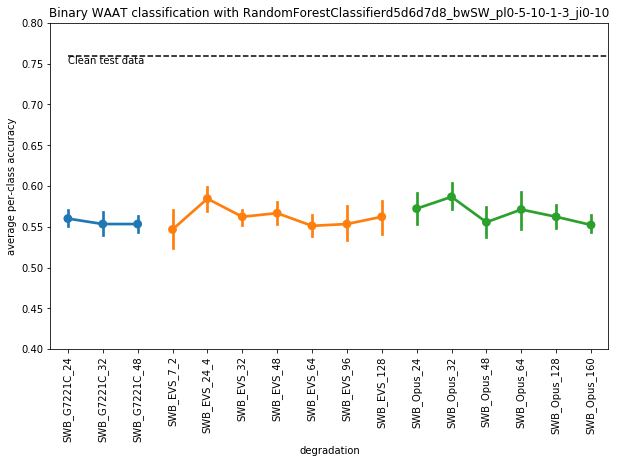

In [11]:
# super-wideband degradations

for c in np.arange(tuning_all.shape[0]):
    test_performance = pd.read_csv(r'.\performance_channels\cls_test_distortionsdegradations_'+tuning_all.loc[c,'classifiers_names']+'_'+label+'.csv')
    bw=['SW']
    pl=list(test_performance['packetlossrate'].unique().astype(str))
    ji=list(test_performance['jitterms'].unique().astype(str))
    plot_performance_across_deg_dist(test_performance, bw, pl, ji)

Examining effect of packet loss and jitter:

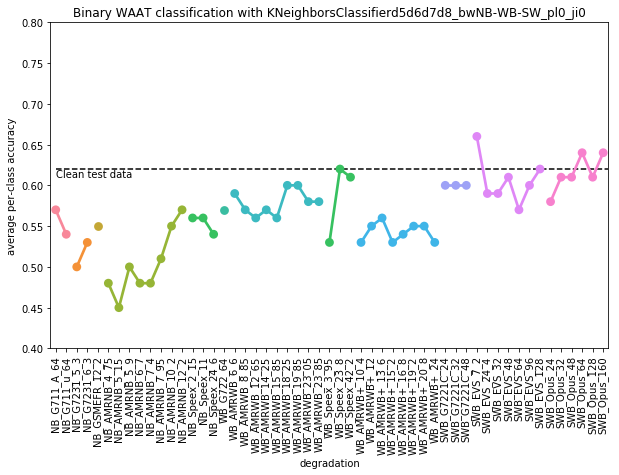

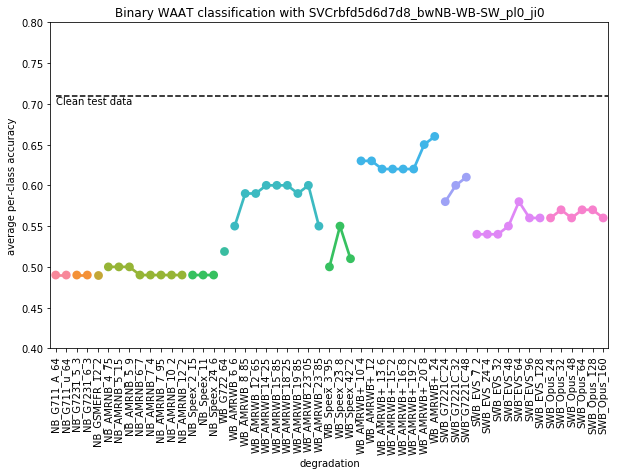

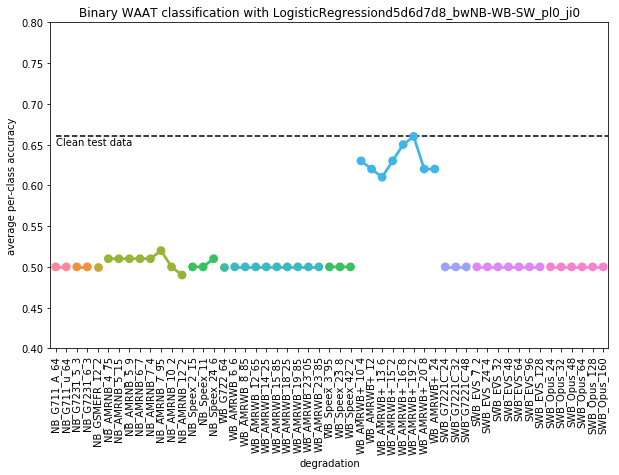

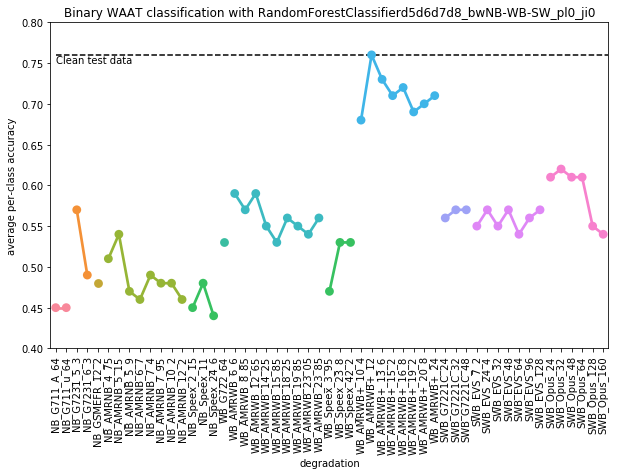

In [12]:
# all bandwidths, max packet loss and max jitter

for c in np.arange(tuning_all.shape[0]):
    test_performance = pd.read_csv(r'.\performance_channels\cls_test_distortionsdegradations_'+tuning_all.loc[c,'classifiers_names']+'_'+label+'.csv')
    bw=['NB','WB','SW']
    pl=['0']
    ji=['0']
    plot_performance_across_deg_dist(test_performance, bw, pl, ji)

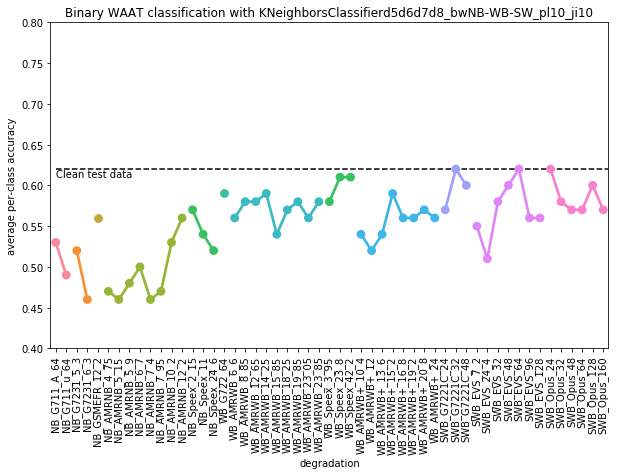

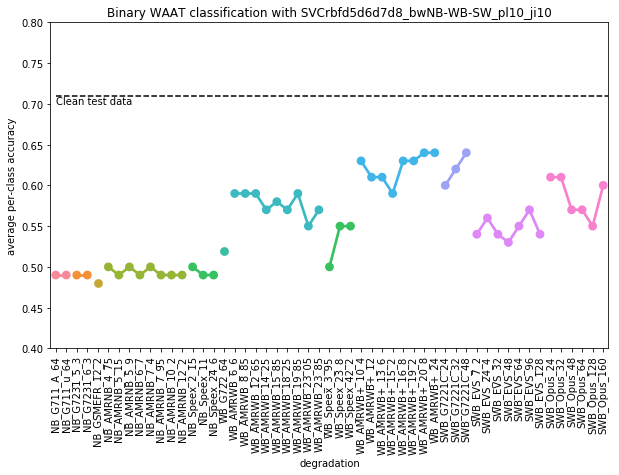

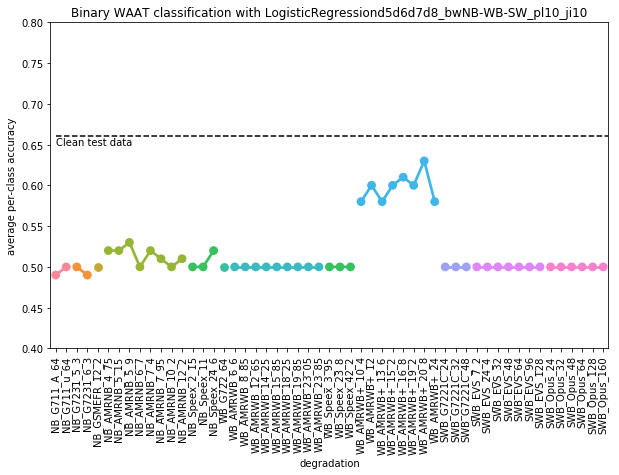

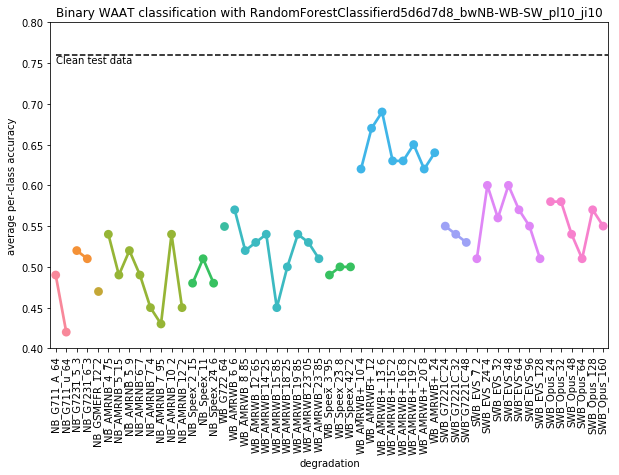

In [13]:
# all bandwidths, max packet loss and max jitter

for c in np.arange(tuning_all.shape[0]):
    test_performance = pd.read_csv(r'.\performance_channels\cls_test_distortionsdegradations_'+tuning_all.loc[c,'classifiers_names']+'_'+label+'.csv')
    bw=['NB','WB','SW']
    pl=['10']
    ji=['10']
    plot_performance_across_deg_dist(test_performance, bw, pl, ji)

Summary: 

* Binary classification of speakers into high or low WAAT (same task as in [Part 02](https://github.com/laufergall/ML_Speaker_Characteristics/blob/master/classification/02_evaluating_classification_WAAT.ipynb)).

* Train data: all clean microphone data from semispontaneous dialogs from 300 speakers (d5, d6, d7, d8, each segmented into 3 parts).

* Test data: stimuli files (shortened versions of d6) segmented into 2 parts -> same speakers yet different content as in Train. Clean, degraded, and distorted speech versions.

* Classifiers trained with nested hyperparameter tuning as in [Part 02](https://github.com/laufergall/ML_Speaker_Characteristics/blob/master/classification/02_evaluating_classification_WAAT.ipynb)). Average per-class accuracy as performance metric.


About the classifiers:

* KNN performance greatly differs between validation and test, which may indicate overfitting. 
* In contrast, LR and RF offer more similar performances comparing dev and test sets (around 0.72). 
* SVC rbf provides the best performance on the test set for the WAAT classification of clean speech with different database partitions: a) the partition in this notebook (same speakers and different content) and b) the partition in [Part 02](https://github.com/laufergall/ML_Speaker_Characteristics/blob/master/classification/02_evaluating_classification_WAAT.ipynb)) (unseen speakers in the test set).


The results indicate that:

* The performance with NB speech is close to that of random guessing (around 50%), with and without jitter and packet loss conditions, and for the SVC, LR, and RF

* None of the channel conditions lead to equal or superior performance than that with clean speech, except for the codec AMRWB+ in WB - for the LR and the RF classifiers and with jitter = 0 and packet loss = 0.


(... TODO)
    
It can be concluded that

% ---

* None of the channel conditions permit performance close to that of clean speech.

* The performance in NB is worse than that in WB and in SWB, which indicates the strong influence of transmission bandwidth. In adition, WB offers somewhat better performance than SWB. Hence, we can conclude that the missing frequencies in NB (specially those from 3400 to 7000 Hz) play a crucial role for correct WAAT classification.

* For SVC: The AMR-WB codec seems to provide the best performance over the conditions of this study (SVC).

* No advantage of increased bitrate was observed for any codec, except for SWB_G.722.1C for SVC and NB_AMRNB for KNN.

* There is no clear tendency that higher packet loss rates and jitter affect the performance.
    * KNN: 
        * in NB, the performance tends to drop from when 10% packet loss is inserted.
        * in WB and SWB, performance is not severely affected. For some conditions (SWB_EVS_64 and SWB_Opus_24), the performance even improves greatly - this might be just due to chance.
    * SVC: 
        * in WB and SWB, performance is not severely affected. For some conditions, the performance even improves greatly - this might be just due to chance.

